# Facial Expression Recognition Pipeline

This notebook implements a complete machine learning pipeline for recognizing facial expressions from the FER2013 dataset. The process includes data loading, exploratory data analysis, feature engineering, model training, and evaluation, following the steps outlined in the project description.

## 1. Setup and Library Imports

First, we import all the necessary libraries. We'll also set up a new virtual environment as recommended to manage dependencies, especially for `PyFUME` and `dlib`.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import dlib
import pickle
from pathlib import Path

# Preprocessing and Feature Extraction
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Machine Learning Models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from pyfume import pyFUME

# Model Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define constants
IMG_WIDTH, IMG_HEIGHT = 48, 48
EMOTION_LABELS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Ensure necessary directories exist
Path('models').mkdir(exist_ok=True)
Path('data').mkdir(exist_ok=True)

print('Libraries imported successfully!')

Libraries imported successfully!


**Note:** Before proceeding, make sure you have downloaded the `fer2013.csv` file and placed it in a `data` directory. Also, download the `shape_predictor_68_face_landmarks.dat` file for dlib and place it in the `data` directory.

## 2. Data Loading and Parsing

We load the dataset from the `fer2013.csv` file. The 'pixels' column, which is a string of space-separated integers, will be converted into 48x48 numpy arrays.

In [23]:
def parse_pixels(pixel_string):
    """Converts a string of pixels into a 48x48 numpy array."""
    return np.array(pixel_string.split(), 'int').reshape(IMG_WIDTH, IMG_HEIGHT)

def load_data(file_path):
    """Loads the FER2013 dataset and splits it into train, public test, and private test sets."""
    df = pd.read_csv(file_path)
    df['pixels'] = df['pixels'].apply(parse_pixels)
    
    df_train = df[df['Usage'] == 'Training']
    df_public_test = df[df['Usage'] == 'PublicTest']
    df_private_test = df[df['Usage'] == 'PrivateTest']
    
    X_train = np.stack(df_train['pixels'].values)
    y_train = df_train['emotion'].values
    
    X_public = np.stack(df_public_test['pixels'].values)
    y_public = df_public_test['emotion'].values
    
    X_private = np.stack(df_private_test['pixels'].values)
    y_private = df_private_test['emotion'].values
    
    return (X_train, y_train), (X_public, y_public), (X_private, y_private)

# Load the data
file_path = 'data/fer2013.csv'
(X_train, y_train), (X_public, y_public), (X_private, y_private) = load_data(file_path)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Public test data shape: {X_public.shape}, Labels shape: {y_public.shape}")
print(f"Private test data shape: {X_private.shape}, Labels shape: {y_private.shape}")

Training data shape: (28709, 48, 48), Labels shape: (28709,)
Public test data shape: (3589, 48, 48), Labels shape: (3589,)
Private test data shape: (3589, 48, 48), Labels shape: (3589,)


## 3. Exploratory Data Analysis (EDA)

Let's visualize some of the images from each class and analyze the class distribution to understand the data imbalance.

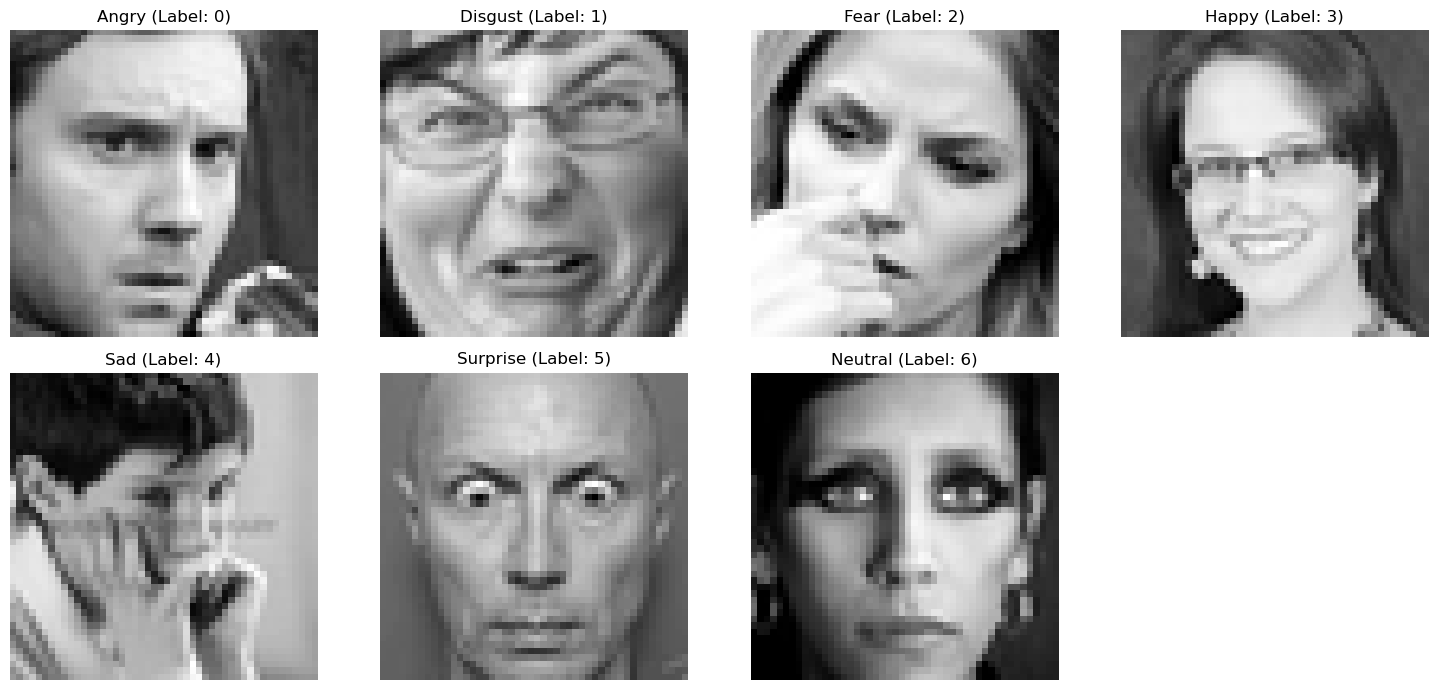

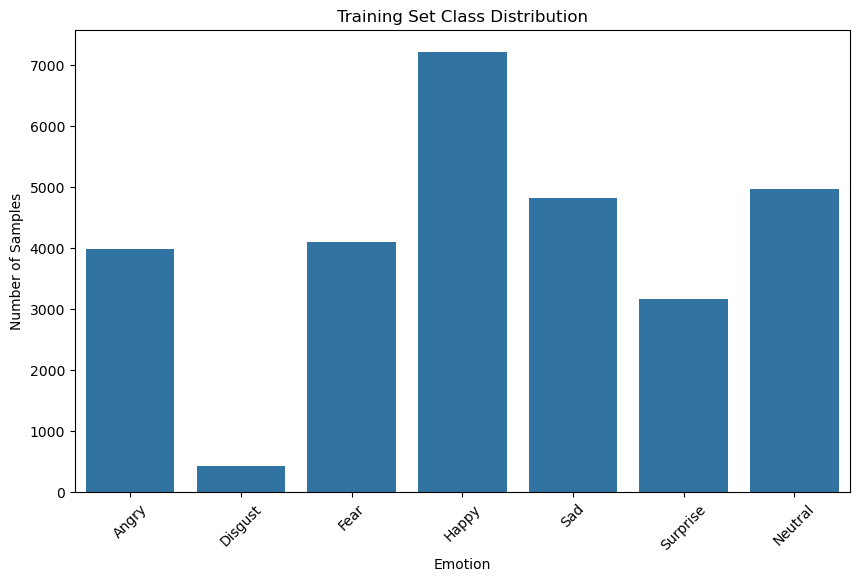

In [24]:
# Visualize sample images
plt.figure(figsize=(15, 7))
for i, (label, emotion_name) in enumerate(EMOTION_LABELS.items()):
    plt.subplot(2, 4, i + 1)
    img = X_train[y_train == label][0] # Get the first image for each class
    plt.imshow(img, cmap='gray')
    plt.title(f'{emotion_name} (Label: {label})')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Analyze class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(y_train).map(EMOTION_LABELS), order=EMOTION_LABELS.values())
plt.title('Training Set Class Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Emotion')
plt.xticks(rotation=45)
plt.show()



## 4. Data Preprocessing and Augmentation

### 4.1. Data Augmentation
We'll apply horizontal flipping to augment the training data.

In [25]:
def augment_data(images, labels):
    flipped_images = np.array([cv2.flip(img, 1) for img in images])
    augmented_images = np.concatenate((images, flipped_images))
    augmented_labels = np.concatenate((labels, labels))
    return augmented_images, augmented_labels

X_train_aug, y_train_aug = augment_data(X_train, y_train)
print(f"Augmented training data shape: {X_train_aug.shape}")

Augmented training data shape: (57418, 48, 48)


### 4.2. Handling Class Imbalance with SMOTE

We apply SMOTE to the training data. Note that SMOTE operates on feature vectors, not images directly. So, we'll apply this *after* feature extraction.

## 5. Feature Engineering

We will define functions to extract three types of features: Local Binary Patterns (LBP), Histogram of Oriented Gradients (HOG), and Facial Landmarks.

In [28]:
import numpy as np
import dlib
from skimage.feature import hog, local_binary_pattern

# --- Feature Extraction Functions ---

def extract_lbp_features(images):
    """Extracts Local Binary Pattern (LBP) features from a list of images."""
    lbp_features = []
    for img in images:
        # P=8 (8 neighbors), R=1 (radius 1), 'uniform' method is robust to rotation
        lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
        # Create a histogram of the LBP result. For 'uniform', there are P+2 (10) bins.
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_features.append(hist)
    return np.array(lbp_features)

def extract_hog_features(images):
    """Extracts Histogram of Oriented Gradients (HOG) features."""
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Load the dlib shape predictor model
# Make sure you have downloaded this file and placed it in the 'data' directory.
try:
    predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
    predictor = dlib.shape_predictor(predictor_path)
except RuntimeError:
    print(f"Error: Could not find '{predictor_path}'. Please download it.")
    predictor = None

def extract_landmark_features(images):
    """Extracts facial landmark features using dlib."""
    if predictor is None:
        raise RuntimeError("dlib shape predictor is not loaded. Cannot extract features.")
        
    landmark_features = []
    # Since all images are 48x48 cropped faces, we define the bounding box once.
    face_rect = dlib.rectangle(left=0, top=0, right=47, bottom=47)
    
    for img in images:
        # dlib expects 8-bit images (0-255)
        img_8bit = img.astype('uint8')
        
        # Directly predict landmarks on the entire image
        shape = predictor(img_8bit, face_rect)
        coords = np.array([[p.x, p.y] for p in shape.parts()])
        
        # Normalize coordinates relative to the nose tip (landmark 30) for consistency
        coords_normalized = coords - coords[30]
        landmark_features.append(coords_normalized.flatten())
            
    return np.array(landmark_features)

# --- New Function to Combine All Features ---
def extract_combined_features(images):
    """A wrapper function to extract and combine all features."""
    print(f"Extracting LBP, HOG, and Landmark features for {len(images)} images...")
    
    # Extract each type of feature
    lbp = extract_lbp_features(images)
    hog = extract_hog_features(images)
    landmarks = extract_landmark_features(images)
    
    # Concatenate features horizontally to create one feature vector per image
    combined_features = np.hstack([lbp, hog, landmarks])
    
    return combined_features

### 5.1. Extracting and Preparing Features for All Datasets

In [29]:
print("Extracting HOG features...")
X_train_hog = extract_hog_features(X_train_aug)
X_public_hog = extract_hog_features(X_public)
X_private_hog = extract_hog_features(X_private)
print("HOG feature extraction complete.")

# Apply SMOTE to HOG features
print("Applying SMOTE to HOG features...")
smote = SMOTE(random_state=42)
X_train_hog_smote, y_train_hog_smote = smote.fit_resample(X_train_hog, y_train_aug)
print(f"HOG features shape after SMOTE: {X_train_hog_smote.shape}")

# Feature Scaling
scaler_hog = StandardScaler()
X_train_hog_scaled = scaler_hog.fit_transform(X_train_hog_smote)
X_public_hog_scaled = scaler_hog.transform(X_public_hog)
X_private_hog_scaled = scaler_hog.transform(X_private_hog)
print("HOG features scaled.")

# Save the scaler for the demo
with open('models/scaler_hog.pkl', 'wb') as f:
    pickle.dump(scaler_hog, f)

Extracting HOG features...
HOG feature extraction complete.
Applying SMOTE to HOG features...
HOG features shape after SMOTE: (101010, 900)
HOG features scaled.


### 5.2. Dimensionality Reduction with PCA (for Fuzzy System)

In [30]:
print("Applying PCA for Fuzzy System...")
# Use un-augmented, un-SMOTEd data for fitting PCA to represent original variance
X_train_unaug_hog = extract_hog_features(X_train)
scaler_pca = StandardScaler()
X_train_unaug_hog_scaled = scaler_pca.fit_transform(X_train_unaug_hog)

pca = PCA(n_components=0.95) # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_unaug_hog_scaled)
print(f"Original HOG dimensions: {X_train_unaug_hog_scaled.shape[1]}")
print(f"PCA-reduced dimensions: {X_train_pca.shape[1]}")

# Now transform the SMOTEd training set and test sets with the fitted PCA
X_public_pca = pca.transform(scaler_pca.transform(X_public_hog))
X_private_pca = pca.transform(scaler_pca.transform(X_private_hog))

# We need to apply SMOTE after PCA for the training data
X_train_hog_for_pca_smote = pca.transform(scaler_pca.transform(extract_hog_features(X_train_aug)))
X_train_pca_smote, y_train_pca_smote = smote.fit_resample(X_train_hog_for_pca_smote, y_train_aug)

# Save PCA object
with open('models/pca_hog.pkl', 'wb') as f:
    pickle.dump(pca, f)
with open('models/scaler_pca.pkl', 'wb') as f:
    pickle.dump(scaler_pca, f)

Applying PCA for Fuzzy System...
Original HOG dimensions: 900
PCA-reduced dimensions: 277


## 6. Model Training and Hyperparameter Tuning

We will now train the four specified models using GridSearchCV to find the best hyperparameters. We'll focus on the HOG features as they often provide a good balance of performance and complexity.

### 6.1. Support Vector Machine (SVM)

In [ ]:
print("Training SVM...")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf'] # RBF is generally good for image features
}

grid_svm = GridSearchCV(SVC(class_weight='balanced'), param_grid_svm, refit=True, verbose=2, cv=3, n_jobs=-1)
grid_svm.fit(X_train_hog_scaled, y_train_hog_smote)

print("Best SVM parameters found: ", grid_svm.best_params_)
svm_best = grid_svm.best_estimator_

# Save the best SVM model
with open('models/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_best, f)

Training SVM...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


### 6.2. Multi-Layer Perceptron (MLP)

In [ ]:
print("Training MLP...")
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

grid_mlp = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), param_grid_mlp, refit=True, verbose=2, cv=3, n_jobs=-1)
grid_mlp.fit(X_train_hog_scaled, y_train_hog_smote)

print("Best MLP parameters found: ", grid_mlp.best_params_)
mlp_best = grid_mlp.best_estimator_

# Save the best MLP model
with open('models/mlp_model.pkl', 'wb') as f:
    pickle.dump(mlp_best, f)

### 6.3. Random Forest

In [ ]:
print("Training Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, refit=True, verbose=2, cv=3, n_jobs=-1)
grid_rf.fit(X_train_hog_scaled, y_train_hog_smote)

print("Best Random Forest parameters found: ", grid_rf.best_params_)
rf_best = grid_rf.best_estimator_

# Save the best Random Forest model
with open('models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_best, f)

### 6.4. Fuzzy Inference System

In [ ]:
from imblearn.over_sampling import SMOTE

# --- Apply SMOTE to the PCA-transformed training data ---

print("Applying SMOTE to balance the training set...")

# Initialize SMOTE. random_state ensures results are reproducible.
smote = SMOTE(random_state=42)

# Resample the training data. This creates BOTH the features and the labels.
# Assumes you have X_train_pca and y_train from previous steps.
X_train_pca_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

print("SMOTE applied successfully.")
print(f"Shape of data after SMOTE: {X_train_pca_smote.shape}")
print(f"Shape of labels after SMOTE: {y_train_smote.shape}")

In [ ]:
print("Training Fuzzy System...")
# Manually iterate through cluster numbers to find the best one for the ANFIS model.
# Note: pyFUME's ANFIS classifier requires integer labels (not one-hot encoded).

best_fuzzy_model = None
best_fuzzy_accuracy = 0.0
best_nr_clus = 0

# Define training parameters that will be passed to the .fit() method
training_params = {'epochs': 50}

for nr_clus in range(3, 8):
    print(f"--- Training Fuzzy model with {nr_clus} clusters ---")
    try:
        # 1. Instantiate the model
        fuzzy_model = pyFUME(model_type='ANFIS')
        
        # 2. Define model-specific parameters
        model_params = {'nr_clus': nr_clus}
        
        # 3. Fit the model. This single step handles the full training process.
        fuzzy_model.fit(
            X_train_pca_smote, 
            y_train_smote, 
            model_params=model_params, 
            training_params=training_params
        ) 
        
        # 4. Predict directly on the test set. 
        # The .predict() method for classification returns the final class labels.
        y_pred_fuzzy = fuzzy_model.predict(X_public_pca)
        accuracy = accuracy_score(y_public, y_pred_fuzzy)
        
        print(f"Accuracy with {nr_clus} clusters: {accuracy:.4f}")
        
        # Check if this model is the best one so far
        if accuracy > best_fuzzy_accuracy:
            best_fuzzy_accuracy = accuracy
            best_fuzzy_model = fuzzy_model
            best_nr_clus = nr_clus
            
    except Exception as e:
        print(f"Could not train with {nr_clus} clusters. Error: {e}")
        continue

print(f"\nBest Fuzzy model found with {best_nr_clus} clusters and accuracy {best_fuzzy_accuracy:.4f} ✨")

# Save the best Fuzzy model
if best_fuzzy_model:
    with open('models/fuzzy_model.pkl', 'wb') as f:
        pickle.dump(best_fuzzy_model, f)
    print("Best fuzzy model saved to 'models/fuzzy_model.pkl'")

## 7. Model Evaluation

Now we evaluate the performance of our four tuned models on the held-out public and private test sets.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """Calculates and prints accuracy and classification report."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=EMOTION_LABELS.values())
    
    print(f"--- Evaluation for {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=EMOTION_LABELS.values(), yticklabels=EMOTION_LABELS.values())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy

# Load models (in case kernel restarted)
svm_model = pickle.load(open('models/svm_model.pkl', 'rb'))
mlp_model = pickle.load(open('models/mlp_model.pkl', 'rb'))
rf_model = pickle.load(open('models/rf_model.pkl', 'rb'))
fuzzy_model = pickle.load(open('models/fuzzy_model.pkl', 'rb'))

models = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "Random Forest": rf_model
}

results = {}

# Evaluate on Public Test Set
print("\n===== EVALUATION ON PUBLIC TEST SET =====\n")
for name, model in models.items():
    acc = evaluate_model(model, X_public_hog_scaled, y_public, f"{name} (Public)")
    results[f"{name}_public_acc"] = acc

# Evaluate Fuzzy on Public Test Set
y_pred_fuzzy_raw = fuzzy_model.predict(X_public_pca)
y_pred_fuzzy = np.argmax(y_pred_fuzzy_raw, axis=1)
acc_fuzzy_public = accuracy_score(y_public, y_pred_fuzzy)
print(f"Accuracy for Fuzzy (Public): {acc_fuzzy_public:.4f}")
results["Fuzzy_public_acc"] = acc_fuzzy_public


# Evaluate on Private Test Set
print("\n===== EVALUATION ON PRIVATE TEST SET =====\n")
for name, model in models.items():
    acc = evaluate_model(model, X_private_hog_scaled, y_private, f"{name} (Private)")
    results[f"{name}_private_acc"] = acc

# Evaluate Fuzzy on Private Test Set
y_pred_fuzzy_raw = fuzzy_model.predict(X_private_pca)
y_pred_fuzzy = np.argmax(y_pred_fuzzy_raw, axis=1)
acc_fuzzy_private = accuracy_score(y_private, y_pred_fuzzy)
print(f"Accuracy for Fuzzy (Private): {acc_fuzzy_private:.4f}")
results["Fuzzy_private_acc"] = acc_fuzzy_private

## 8. Conclusion and Model Selection

Finally, we compare the results and select the best model for the real-time demonstration. The choice will be based on a balance of accuracy on the private test set and computational efficiency.

In [ ]:
print("--- Final Performance Summary ---")
results_df = pd.DataFrame({
    'Model': ['SVM', 'MLP', 'Random Forest', 'Fuzzy System'],
    'Public Test Accuracy': [results['SVM_public_acc'], results['MLP_public_acc'], results['Random Forest_public_acc'], results['Fuzzy_public_acc']],
    'Private Test Accuracy': [results['SVM_private_acc'], results['MLP_private_acc'], results['Random Forest_private_acc'], results['Fuzzy_private_acc']]
})

print(results_df)

best_model_name = results_df.sort_values(by='Private Test Accuracy', ascending=False).iloc[0]['Model']
print(f"\nBased on the private test accuracy, the best model is: {best_model_name}")
print("This model will be used for the real-time demo.")